> 1. DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.
> 2. SET THE "General Access" OF THE COPIED NOTEBOOK TO "Anyone with the link" BY CLICKING ON "Share" TO ENABLE SHARING WITH YOUR PEERS FOR REVIEW.


### This project is from the *Causal Inference for Data Science course on CoRise.* Learn more about the course [here](https://corise.com/course/causal-inference-for-data-science).



---





# Week 1 Project: Applying Linear Regression
***

Welcome to the first project for Causal Inference for Data Science!


## Scenario

Throughout this course, you will assume the role of a Data Scientist for Tongass, a retailer that sells goods online and in physical stores.

One day, a Tongass executive passes by your desk (or Zoom square) and asks, "Hey, you know things about data, right?"

"I like to think so," you reply as you lean back into your seat.

"Great... Because I've been thinking... How much of a benefit do we get from our physical stores anyway?"

"Benefit?" you ask.

"Like, if we can convince a customer to shop in person, does that boost their ultimate value to Tongass?"

"Hmmm," you say, "an interesting and important question. I'll look into it and report back!"

**This is the question we'll be interested in tackling — not only this week, but in weeks to come.**


## Project notes

### Data

We will work with a consistent data set througout this course (we introduce the data set more fully below). Not all parts of the data set will be applicable in any given week. The goal is demonstrating how a single set of granular data can be transformed to apply different causal inference techniques. We also hope to convey that manipulating data is in many ways the most important aspect of statistical modeling.

### Structure

We attempt to strike a balance between providing concrete steps to follow and making room for exploration. That said, we encourage you to explore: The best way to become a causal inference expert is to attack a single problem from multiple angles to see how different modeling choices affect an analysis. If this freedom is overwhelming, **don't panic**! You can simply fill out the code blocks marked "TODO" and ignore the optional ones. When we ask you to build models, we will provide the treatment effect you should expect so you can check your work.

In [ ]:
# loading necessary packages
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import statsmodels.formula.api as smf

<br/>

## I. Load the data
***

We will work with a consistent data set throughout this course. The data set is in the file called `tongass_transactions.csv`.

Note: The data set is at the **transaction level**, not the customer level. Any given customer can (and likely does) have multiple transactions. Some measures and fields are at the customer level, while others are at the transaction level. It will be up to you to manipulate this data set so that it can be used for analysis. Note that the question we're interested in is fundamentally about *customers, not transactions,* which means we'll likely need to aggregate the data to the customer level to make it useful.

Below, we define the fields that are relevant for this week:
- `customer_id`: the unique identifier for a given customer
- `age`: the age of the customer
- `income`: the income of the customer
- `state`: the customer's state of residence
- `distance`: the distance (in miles) from a customer's home to the nearest Tongass store
- `tx_order`: whether the transaction is the customer's first, second, third... etc.
- `amount`: the dollar value of the transaction
- `tx_date`: the date of the transaction
- `is_credit`: whether the transaction involved a credit card or a different payment method (1 if credit card, 0 if other)
- `in_store`: whether the transaction happened in a physical store (1 if yes, 0 if no and happened on tongass.com)

**NOTE**: If we don't mention a field above, then it won't be relevant for this week :)

In [ ]:
# TODO: read in data (already filled out for you :)
url = 'https://raw.githubusercontent.com/dsaber/co-rise-causal-inference/main/tongass_transactions.csv'
df = pd.read_csv(url)
df.head()

,customer_id,age,income,state,received_re,received_in_store_re,distance,index,tx_order,amount,in_store,tx_date,is_credit,is_bonus
0,0,65,122753,ND,0,0,6.765402,0,0.0,61.964375,0.0,2020-12-31,0.0,0.0
1,0,65,122753,ND,0,0,6.765402,1,1.0,41.057234,0.0,2021-03-31,0.0,0.0
2,0,65,122753,ND,0,0,6.765402,2,2.0,71.752128,1.0,2021-06-30,1.0,0.0
3,0,65,122753,ND,0,0,6.765402,3,3.0,93.129942,1.0,2022-10-31,1.0,0.0
4,1,79,32977,DC,0,0,3.146723,0,0.0,61.334116,0.0,2020-01-31,0.0,0.0


<br/>

## II. Familiarize yourself with the data set and determine if the causal question is worth investigating (spoiler: it will be)
***

Before we build any models, we should deeply understand the data set we're working with.

In this section, you are free to do anything you would typically do when working with a new set of data; however, at a minimum, we recommend:
- Visualizing at least three key distributions (e.g., the number of transactions per customer, the dollar value of transactions/customers, etc.).
- Investigating whether the key causal question is worth investigating (e.g., by looking at whether customers who shop in store spend more money overall). One simple way to do this could be by looking at how customer value varies with the proportion of their transactions that occur in a physical store.
- Looking at which other variables might relate to customer value (e.g., age, income).

To get you started, we visualize a distribution below.

In [ ]:
dfc = df.groupby('customer_id').agg({
    'tx_order': 'count',
    'amount': 'sum',
    'in_store': 'mean',
    'distance': 'first',
    'age': 'first',
    'income': 'mean',
    'is_credit': 'mean'
    }).rename(columns={'tx_order': 'num_transactions', 'amount': 'customer_value'}).reset_index()

[Text(0.5, 0, 'Number of transactions'),
 Text(0, 0.5, 'Number of customers'),
 Text(0.5, 1.0, 'Number of customers with X transactions')]

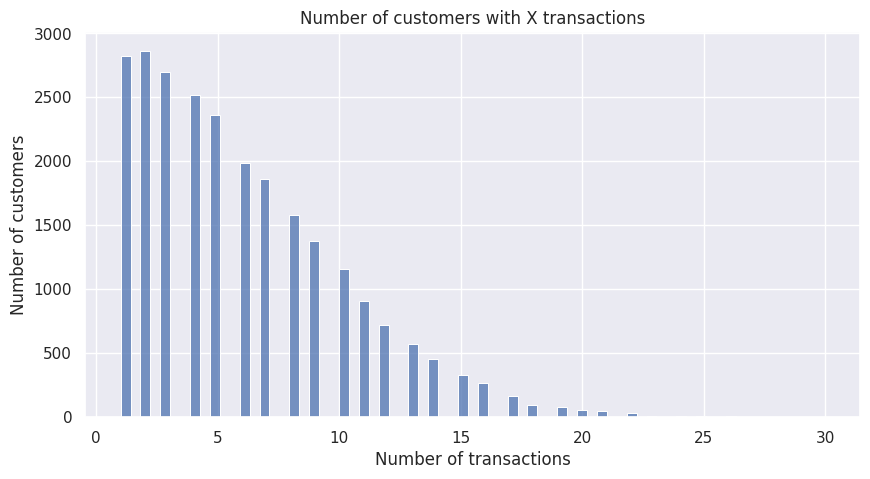

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.histplot(dfc['num_transactions'], ax=ax)
ax.set(
    xlabel='Number of transactions',
    ylabel='Number of customers',
    title='Number of customers with X transactions'
)

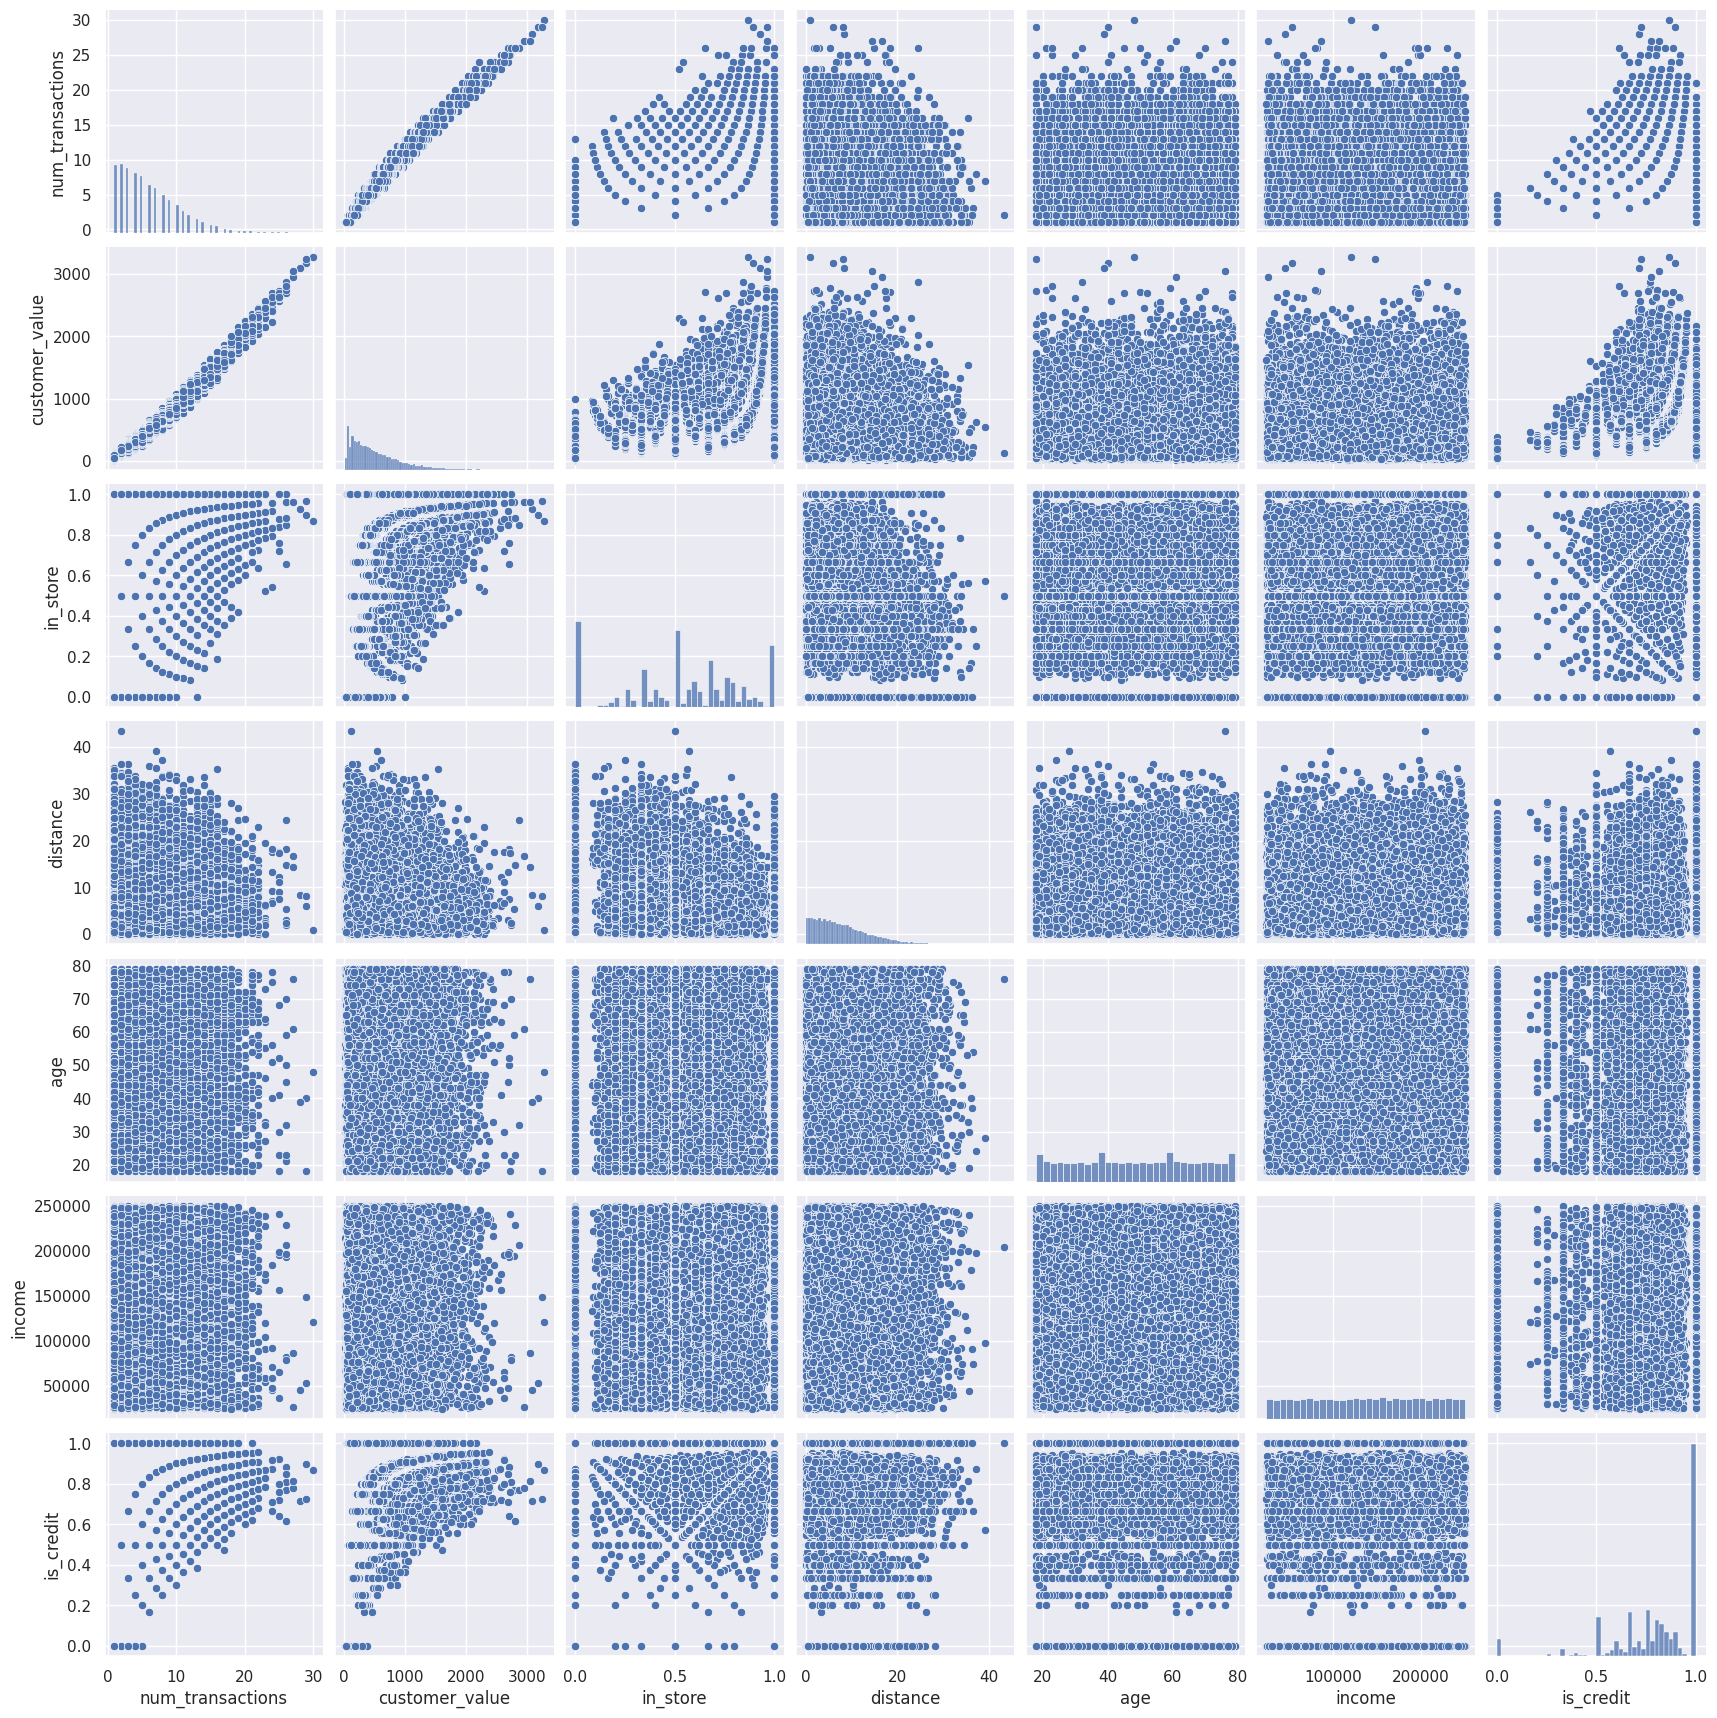

In [ ]:
pl = sns.pairplot(dfc.drop('customer_id', axis=1))
ax = pl.axes

[Text(0.5, 0, 'In-store'),
 Text(0, 0.5, 'Customer Value'),
 Text(0.5, 1.0, 'In-store purchases vs. Customer Value')]

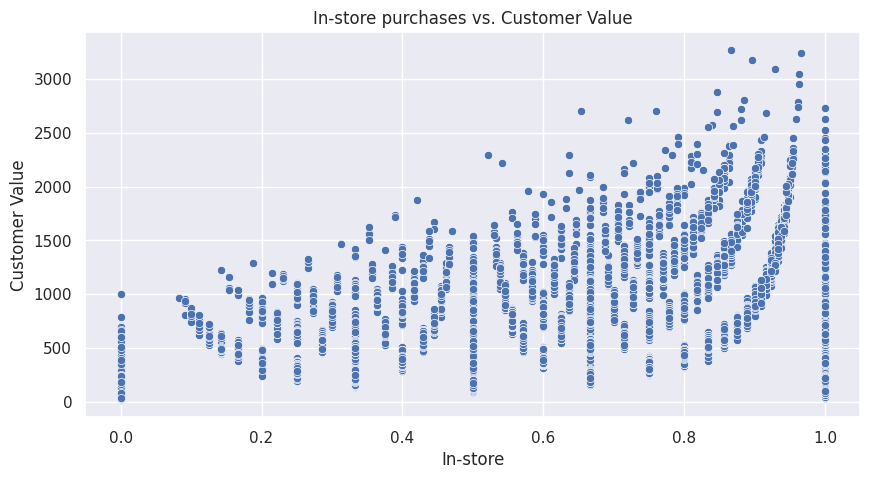

In [ ]:
# TODO: determine if customer value seems correlated with in-store shopping
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.scatterplot(x='in_store', y='customer_value', data=dfc, ax=ax)
ax.set(
    xlabel='In-store',
    ylabel='Customer Value',
    title='In-store purchases vs. Customer Value'
)




[Text(0.5, 0, 'In-store'),
 Text(0, 0.5, 'Number of transactions'),
 Text(0.5, 1.0, 'Number of transactions in store')]

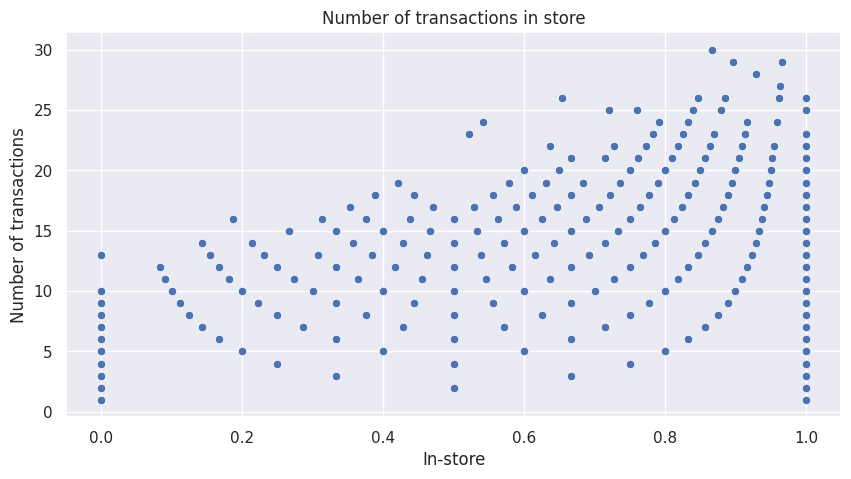

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.scatterplot(x='in_store', y='num_transactions', data=dfc, ax=ax)
ax.set(
    xlabel='In-store',
    ylabel='Number of transactions',
    title='Number of transactions in store'
)

[Text(0.5, 0, 'In-store'),
 Text(0, 0.5, 'Distance'),
 Text(0.5, 1.0, 'In-store purchases vs. distance to store')]

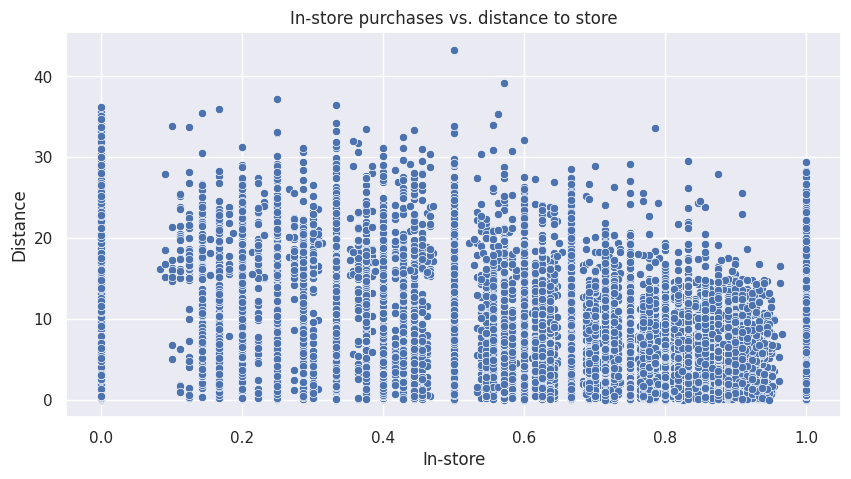

In [ ]:
# TODO: determine if other variables (e.g., number of transactions, age, distance, etc.)
# seems correlated with in-store shopping

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.scatterplot(x='in_store', y='distance', data=dfc, ax=ax)
ax.set(
    xlabel='In-store',
    ylabel='Distance',
    title='In-store purchases vs. distance to store'
)

[Text(0.5, 0, 'Customer Value'),
 Text(0, 0.5, 'Customer ID'),
 Text(0.5, 1.0, 'Dollar Value per Customer')]

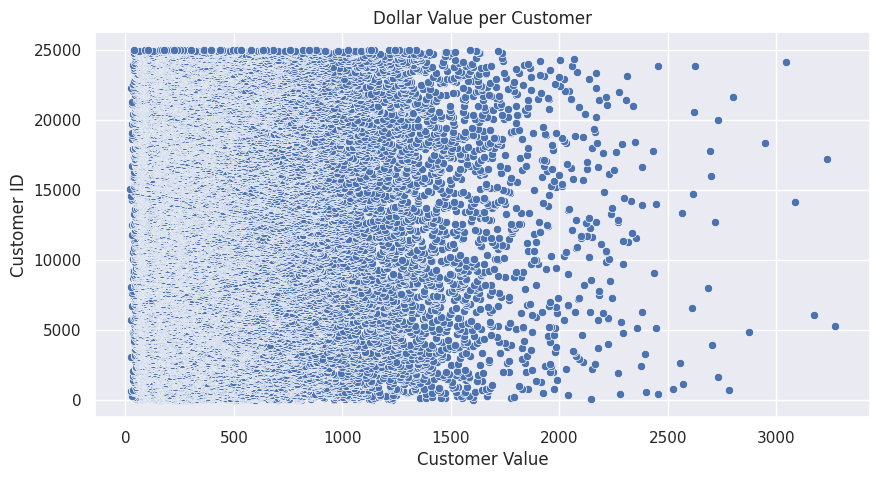

In [ ]:
# TODO: visualize a key distribution (e.g., dollar value per customer, dollar value per customer cohort, etc.)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.scatterplot(x='customer_value', y='customer_id', data=dfc, ax=ax)
ax.set(
    xlabel='Customer Value',
    ylabel='Customer ID',
    title='Dollar Value per Customer'
)

[Text(0.5, 0, 'In-store'),
 Text(0, 0.5, 'Customer Age'),
 Text(0.5, 1.0, 'In-store purchases vs. age of customers')]

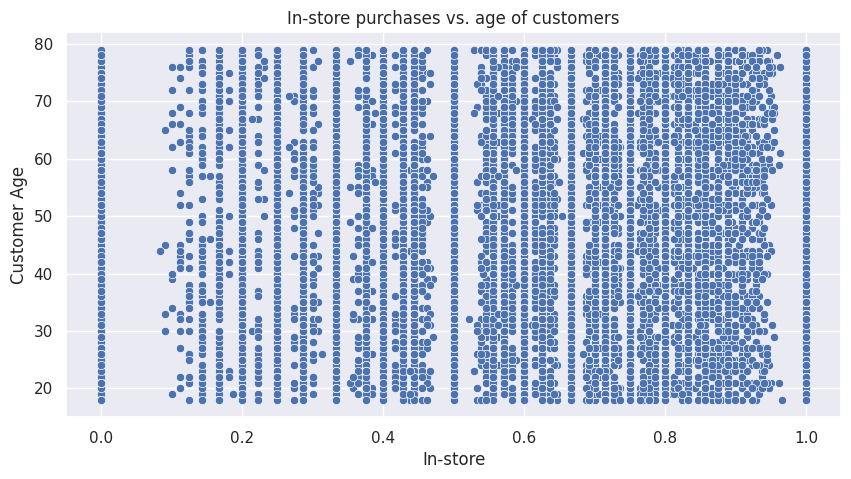

In [ ]:
# TODO: determine if other variables (e.g., number of transactions, age, distance, etc.)
# seems correlated with in-store shopping
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.scatterplot(x='in_store', y='age', data=dfc, ax=ax)
ax.set(
    xlabel='In-store',
    ylabel='Customer Age',
    title='In-store purchases vs. age of customers'
)

## III. Decide how you will approach the causal question of interest and manipulate the data accordingly
***

As you have likely noticed, our Tongass executive asked us a fairly high-level strategic question. They are broadly interested in the relationship between in-store shopping and customer value, but beyond that, they didn't provide additional structure.

In reality, you would have asked them additional follow-ups about how exactly this analysis would inform decision-making, but regardless, "translating" between vague high-level questions and the concrete act of preparing a statistical model is one of the main ways data scientists add value!

So let's do it.

### Approach 1

To start, let's think about the ways you could approach this problem. One simple way might be to say, "Well, we have a bunch of transactions data. We could simply aggregate it at the customer level and see whether customers who have a higher in-store shopping rate are more valuable."

In that case, the data would look something like this...

In [ ]:
df_model1 = df.groupby('customer_id').agg({
    'in_store': 'max', # the rate at which customer shops in store (treatment variable)
    'amount': 'sum', # the total amount a customer has spent (outcome variable)
    'tx_order': 'max', # a key control — the number of transactions this customer makes
    # TODO: if you choose this approach, figure out how to construct the rest of the data set,
    # including key variables like distance, age, etc.
    'distance': 'first',
    'age': 'first',
    'income': 'first',
    'is_credit': 'mean',
    'state': 'first',
    'tx_date': 'min'
}).rename(columns={'tx_order': 'num_transactions', 'amount': 'customer_value'}).reset_index()

print(df_model1.shape)
df_model1.head()

(25000, 10)


,customer_id,in_store,customer_value,num_transactions,distance,age,income,is_credit,state,tx_date
0,0,1.0,267.903678,3.0,6.765402,65,122753,0.500000,ND,2020-12-31
1,1,1.0,1604.529401,16.0,3.146723,79,32977,0.823529,DC,2020-01-31
2,2,1.0,302.195168,3.0,1.578430,23,45734,0.750000,WI,2020-11-30
3,3,1.0,511.422005,6.0,5.121281,46,34358,0.857143,IL,2020-02-29
4,4,1.0,705.293409,7.0,7.128278,24,47111,0.875000,TN,2020-01-31


Approaching the data this way would translate to the following causal problem: **"If we can boost the rate at which the typical customer shops in person, how does their long-run value change?"**

A couple of notes:
1. We're not preparing the data set for you completely — where would the fun be in that? ;)
2. Even in this formulation of the problem, there are still additional choices for us to make. For example, rather than looking at the "in-store shopping rate," we could look at whether a customer ever had *any* in-store transaction. Both decisions are reasonable, and both would communicate something slightly different. It's up to us to decide which concept is more meaningful given the data we have and the strategic decisions we wish to inform. (Don't worry about changing the above code to account for this note — this is mostly to point out there are many subtle ways we can construct data.)

### Approach 2

Alternatively, it could be more elegant (albeit complex) to reframe this problem as happening at a specific point in time to a specific population.

In particular, rather than looking at the data set as a whole, we could pick an arbitrary month and say, **"Hey, let's consider all the customers who only ever shopped online up till that point. The 'treatment' will then be shopping in person for the first time during that month of interest."**

The bones of this data manipulation would look something like this...

In [ ]:
df_model2 = df.copy()
date_range = np.sort(df_model2['tx_date'].unique())

# arbitrarily take middle of date range as month of "intervention"
intervention_month = date_range[len(date_range)//2]

# get customers who had a transaction in month of "intervention"
customers = df_model2[df_model2['tx_date'] == intervention_month][['customer_id', 'in_store']]

df_model2['pre_intervention'] = df_model2['tx_date'] < intervention_month

df_model2 = df_model2.groupby(['customer_id', 'pre_intervention']).agg({
    'in_store': 'max',
    'amount': 'sum',
    'tx_order': 'max', # count number of transactions for this customer
    # TODO: if you choose this approach, figure out how to construct the rest of the data set,
    # including key variables like distance, age, etc.
    'distance': 'first',
    'age': 'first',
    'income': 'first',
    'is_credit': 'mean',
    'state': 'first',
    'tx_date': 'min'
}).rename(columns={'tx_order': 'num_transactions', 'amount': 'customer_value'}).reset_index()




In [ ]:
# filter to customers who only shopped online before "intervention"
df_model2_pre = df_model2[(df_model2['pre_intervention'] == True) & (df_model2['in_store'] == 0)].drop(columns=['customer_value', 'in_store'])

# join on relevant customer population and get "treatment" — whether they
# shopped in store or online during relevant month
df_model2_pre = pd.merge(df_model2_pre, customers, on='customer_id', how='inner')

# get outcome for above customers
df_model2_post = df_model2[df_model2['pre_intervention'] == False][['customer_id', 'customer_value']]

# combine these data sets
df_model2_final = pd.merge(df_model2_pre, df_model2_post, how='left', on='customer_id').fillna(0)

print(df_model2_final.shape)
df_model2_final.head()

(698, 11)


,customer_id,pre_intervention,num_transactions,distance,age,income,is_credit,state,tx_date,in_store,customer_value
0,64,True,1.0,0.951614,33,25834,1.0,AL,2020-01-31,1.0,233.056367
1,67,True,0.0,2.200955,18,145669,1.0,WV,2020-02-29,1.0,263.104737
2,84,True,1.0,9.920939,48,102891,1.0,PA,2020-09-30,1.0,271.067656
3,95,True,3.0,13.419045,76,166848,0.5,HI,2020-01-31,1.0,218.513530
4,139,True,0.0,4.207547,59,248993,1.0,ID,2020-02-29,1.0,148.357707


The code is much more complicated, but it elegantly maps to the following causal question: **"If we convince a purely online shopper to buy something in a store, how much extra value does that generate in the long-run?"**

That's an interesting (and actionable!) question, so it could be worth the data munging pain. Whether you agree is up to you ;)

Also note that this approach _does_ involve throwing out a lot of data. In a future version of this analysis, it might be worth thinking about whether there are ways to structure the problem so that we throw out less, or, if you go down this path, to consider repeating this analysis for different months to see if the result is robust.

**NOTE**: If this framing of the problem seems at all confusing, don't worry! Just go with Approach 1.

### Note on Step III

There's a reason we're spending a lot of time on this section. It might seem silly, but this is often the most complex part of any modeling problem. Once you have your data in place, fitting models and deciding which works best is often a more straightforward task! (as you'll hopefully soon see :)

## IV. Fit a simple (!) baseline model
***

Woohoo! We can finally start modeling.

Fit the simplest possible model you can using `statsmodels` (we recommend a call to [`smf.ols`](https://www.statsmodels.org/stable/example_formulas.html) like we used in the written material). The model should be your outcome regressed against your treatment (and that's it!).

You should see an extremely strong and statistically significant effect. But, of course, a lot of that is simply selection bias, as we'll see.

In [ ]:
# TODO: fit a simple model — just outcome on one side and treatment on the other
# CHECK: if you go with Approach 1, your treatment effect should be ~495; if you go with Approach 2,
# your treatment effect should be ~38

df_model_1_1 = smf.ols('customer_value ~ in_store', data = df_model1).fit()

df_model_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     4217.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        07:31:24   Log-Likelihood:            -1.8390e+05
No. Observations:               25000   AIC:                         3.678e+05
Df Residuals:                   24998   BIC:                         3.678e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    146.1919      6.306     23.185      0.000     133.833     158.551
in_store     442.6490      6.817     64.935      0.000     429.288     456.010
==============================================================================
Omnibus:                     6388.017   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16869.041
Skew:                           1.379   Prob(JB):                         0.00
Kurtosis:                       5.931   Cond. No.                         5.08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## V. Address omitted variable bias (OVB) by interrogating residuals and fitting more complicated models
***

Now that we have a baseline model, we can improve it. This is usually an iterative process.

One useful way to get a handle on OVB is by investigating the residuals in our models. In a "complete" model, it should be hard to find patterns in our residuals. They should look like random noise regardless of which missing variables we plot them against. In an "incomplete" model, finding patterns in our residuals should be easier.

So let's try it.

Plot the residuals of your simple model against key missing explanatory variables (e.g., age, the number of transactions a customer has, etc.). If you see strong patterns, then it suggests we haven't yet achieved conditional independence. Add important variables to your simple model and "build up" to a more complete one, paying special attention to how our effect size and R-squared change over time (the former should eventually stabilize and the latter should increase).

If you haven't come across seaborn's `lmplot` function before, it might be helpful here: https://seaborn.pydata.org/generated/seaborn.lmplot.html

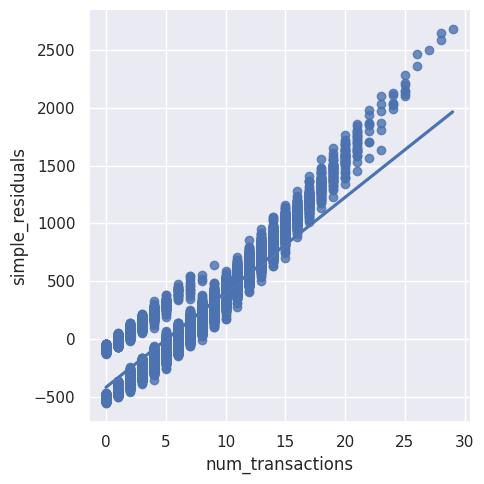

In [ ]:
# TODO: plot residuals from simple model against a key missing variable (e.g., age,
# income, number of transactions, etc.)

df_model1['simple_residuals'] = df_model_1_1.resid

g = sns.lmplot(x='num_transactions', y='simple_residuals', data=df_model1)

In [ ]:
# TODO: fit another regression that incorporates this missing variable

df_model_1_2 = smf.ols('customer_value ~ in_store + num_transactions', data = df_model1).fit()

df_model_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 6.548e+05
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        07:31:51   Log-Likelihood:            -1.3613e+05
No. Observations:               25000   AIC:                         2.723e+05
Df Residuals:                   24997   BIC:                         2.723e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           44.9492      0.938     47.929      0.000      43.111      46.787
in_store           -12.6495      1.097    -11.534      0.000     -14.799     -10.500
num_transactions    96.9705      0.092   1056.886      0.000      96.791      97.150
==============================================================================
Omnibus:                     3074.863   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16562.151
Skew:                           0.474   Prob(JB):                         0.00
Kurtosis:                       6.873   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

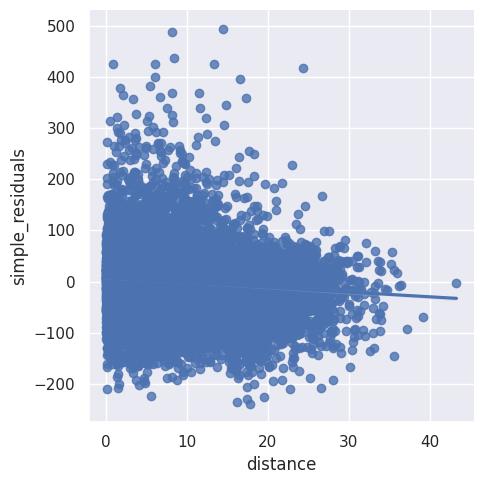

In [ ]:
df_model1['simple_residuals'] = df_model_1_2.resid

g = sns.lmplot(x='distance', y='simple_residuals', data=df_model1)

In [ ]:
df_model_1_3 = smf.ols('customer_value ~ in_store + num_transactions + state', data = df_model1).fit()

df_model_1_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.586e+04
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:06:40   Log-Likelihood:            -1.3578e+05
No. Observations:               25000   AIC:                         2.717e+05
Df Residuals:                   24947   BIC:                         2.721e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           33.2171      2.581     12.871      0.000      28.159      38.275
state[T.AL]          4.6643      3.549      1.314      0.189      -2.291      11.620
state[T.AR]          5.8216      3.553      1.639      0.101      -1.142      12.785
state[T.AZ]         11.6688      3.557      3.280      0.001       4.697      18.641
state[T.CA]         20.2104      3.532      5.722      0.000      13.287      27.134
state[T.CO]         16.9599      3.467      4.892      0.000      10.164      23.756
state[T.CT]         35.4738      3.493     10.155      0.000      28.627      42.320
state[T.DC]         22.7182      3.518      6.459      0.000      15.824      29.613
state[T.DE]         17.1868      3.521      4.882      0.000      10.286      24.087
state[T.FL]          7.6534      3.533      2.166      0.030       0.728      14.579
state[T.GA]         27.7536      3.477      7.982      0.000      20.938      34.569
state[T.HI]          8.6678      3.457      2.507      0.012       1.891      15.444
state[T.IA]         12.3669      3.460      3.574      0.000       5.585      19.149
state[T.ID]         28.4083      3.518      8.076      0.000      21.514      35.303
state[T.IL]         14.4212      3.532      4.083      0.000       7.498      21.344
state[T.IN]          2.7100      3.535      0.767      0.443      -4.220       9.640
state[T.KS]         20.1580      3.485      5.784      0.000      13.327      26.989
state[T.KY]         27.9451      3.515      7.951      0.000      21.056      34.834
state[T.LA]          2.0070      3.543      0.566      0.571      -4.937       8.951
state[T.MA]         22.4712      3.513      6.396      0.000      15.585      29.358
state[T.MD]         14.1843      3.470      4.088      0.000       7.383      20.986
state[T.ME]         11.5998      3.520      3.295      0.001       4.700      18.500
state[T.MI]         27.8844      3.514      7.934      0.000      20.996      34.773
state[T.MN]         12.1953      3.455      3.529      0.000       5.423      18.968
state[T.MO]          9.5630      3.478      2.749      0.006       2.745      16.381
state[T.MS]         13.2188      3.553      3.720      0.000       6.254      20.183
state[T.MT]          6.6061      3.573      1.849      0.065      -0.398      13.610
state[T.NC]          4.6437      3.455      1.344      0.179      -2.127      11.415
state[T.ND]         10.6674      3.475      3.069      0.002       3.856      17.479
state[T.NE]          4.7748      3.475      1.374      0.169      -2.037      11.586
state[T.NH]          4.9929      3.522      1.418      0.156      -1.910      11.896
state[T.NJ]         27.1485      3.522      7.709      0.000      20.245      34.052
state[T.NM]          3.5350      3.509      1.007      0.314      -3.342      10.412
state[T.NV]          3.

In [ ]:
df_model_1_4 = smf.ols('customer_value ~ in_store + num_transactions + distance + age + income + is_credit + state + tx_date', data = df_model1).fit()

df_model_1_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.699e+04
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        07:58:48   Log-Likelihood:            -1.3404e+05
No. Observations:               25000   AIC:                         2.683e+05
Df Residuals:                   24908   BIC:                         2.690e+05
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -39.5827      3.116    -12.704      0.000     -45.690     -33.476
state[T.AL]               1.9367      3.316      0.584      0.559      -4.562       8.436
state[T.AR]               3.7986      3.319      1.144      0.252      -2.707      10.305
state[T.AZ]               9.3787      3.324      2.822      0.005       2.864      15.893
state[T.CA]              18.8349      3.299      5.709      0.000      12.368      25.302
state[T.CO]              15.2751      3.239      4.716      0.000       8.926      21.624
state[T.CT]              33.8752      3.264     10.380      0.000      27.478      40.272
state[T.DC]              19.2562      3.287      5.858      0.000      12.813      25.699
state[T.DE]              15.3165      3.290      4.656      0.000       8.869      21.764
state[T.FL]               5.2103      3.301      1.578      0.114      -1.260      11.680
state[T.GA]              25.1378      3.248      7.739      0.000      18.771      31.505
state[T.HI]               8.1152      3.229      2.513      0.012       1.786      14.445
state[T.IA]              11.0883      3.233      3.430      0.001       4.752      17.425
state[T.ID]              25.4023      3.287      7.727      0.000      18.959      31.846
state[T.IL]              13.8359      3.299      4.194      0.000       7.369      20.303
state[T.IN]               0.2193      3.303      0.066      0.947      -6.255       6.693
state[T.KS]              16.7539      3.256      5.146      0.000      10.372      23.135
state[T.KY]              26.2503      3.283      7.995      0.000      19.815      32.686
state[T.LA]               1.0543      3.310      0.319      0.750      -5.433       7.542
state[T.MA]              20.5766      3.281      6.271      0.000      14.145      27.008
state[T.MD]              11.2726      3.243      3.476      0.001       4.917      17.628
state[T.ME]               8.9827      3.289      2.731      0.006       2.536      15.429
state[T.MI]              24.8982      3.284      7.582      0.000      18.461      31.335
state[T.MN]               9.4685      3.229      2.933      0.003       3.140      15.797
state[T.MO]               6.7252      3.250      2.069      0.039       0.355      13.095
state[T.MS]              10.8328      3.320      3.263      0.001       4.326      17.340
state[T.MT]               4.3466      3.338      1.302      0.193      -2.197      10.890
state[T.NC]               2.8221      3.228      0.874      0.382      -3.505       9.149
state[T.ND]               8.8636      3.246      2.730      0.006       2.501      15.226
state[T.NE]               2.6013      3.247      0.801      0.423      -3.763       8.965
state[T.NH]               3.4273      3.290      1.042      0.298      -3.022       9.877
state[T.NJ]            

In [ ]:
# TODO: repeat above steps for additional variables (e.g., plot residuals from more complex model against
# key missing variables). build up to a more complicated and complete model in an iterative way

# CHECK: Depending on how many controls you include in your "complete" model, your estimated treatment effect
# for Approach 1 could be ~38-53, and your estimated treatment effect for Approach 2 could be ~31-45. That said,
# there is considerable room for variation here depending on the controls you ultimately decide to include

In [ ]:
df_model_2_1 = smf.ols('customer_value ~ in_store', data = df_model2_final).fit()

df_model_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     8.255
Date:                Mon, 04 Dec 2023   Prob (F-statistic):            0.00419
Time:                        07:33:07   Log-Likelihood:                -4588.2
No. Observations:                 698   AIC:                             9180.
Df Residuals:                     696   BIC:                             9189.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    283.8894      9.533     29.780      0.000     265.173     302.606
in_store      37.7721     13.147      2.873      0.004      11.960      63.584
==============================================================================
Omnibus:                      111.400   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.690
Skew:                           1.015   Prob(JB):                     5.80e-40
Kurtosis:                       4.445   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df_model_2_2 = smf.ols('customer_value ~ in_store + num_transactions', data = df_model2_final).fit()

df_model_2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     34.36
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           5.90e-15
Time:                        07:52:19   Log-Likelihood:                -4559.4
No. Observations:                 698   AIC:                             9125.
Df Residuals:                     695   BIC:                             9138.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          240.5253     10.736     22.403      0.000     219.446     261.604
in_store            34.6042     12.631      2.740      0.006       9.805      59.404
num_transactions    43.2334      5.592      7.731      0.000      32.253      54.214
==============================================================================
Omnibus:                       96.741   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.070
Skew:                           0.914   Prob(JB):                     1.57e-33
Kurtosis:                       4.361   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
df_model_2_3 = smf.ols('customer_value ~ in_store + num_transactions + state', data = df_model2_final).fit()


df_model_2_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     2.209
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           5.24e-06
Time:                        08:06:07   Log-Likelihood:                -4535.1
No. Observations:                 698   AIC:                             9176.
Df Residuals:                     645   BIC:                             9417.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          282.8214     34.491      8.200      0.000     215.093     350.550
state[T.AL]        -17.2099     51.230     -0.336      0.737    -117.809      83.389
state[T.AR]        -73.2109     53.086     -1.379      0.168    -177.452      31.031
state[T.AZ]        -47.9060     56.972     -0.841      0.401    -159.779      63.967
state[T.CA]        -61.4298     62.196     -0.988      0.324    -183.560      60.701
state[T.CO]        -68.6430     53.170     -1.291      0.197    -173.051      35.765
state[T.CT]        -65.3479     64.884     -1.007      0.314    -192.758      62.062
state[T.DC]        -77.1612     60.395     -1.278      0.202    -195.755      41.433
state[T.DE]        -71.5672     60.132     -1.190      0.234    -189.644      46.510
state[T.FL]         -0.9220     51.220     -0.018      0.986    -101.500      99.656
state[T.GA]        -42.4342     67.994     -0.624      0.533    -175.951      91.082
state[T.HI]        -40.3124     54.138     -0.745      0.457    -146.621      65.996
state[T.IA]        -72.6352     60.637     -1.198      0.231    -191.705      46.435
state[T.ID]        -44.8143     53.437     -0.839      0.402    -149.746      60.117
state[T.IL]        -83.4102     53.457     -1.560      0.119    -188.382      21.561
state[T.IN]         28.4601     62.197      0.458      0.647     -93.674     150.594
state[T.KS]        -11.3701     64.925     -0.175      0.861    -138.861     116.120
state[T.KY]       -159.0795     89.719     -1.773      0.077    -335.256      17.097
state[T.LA]        -58.3559     50.481     -1.156      0.248    -157.482      40.771
state[T.MA]        -97.9519     58.271     -1.681      0.093    -212.375      16.471
state[T.MD]       -148.5083     55.425     -2.679      0.008    -257.344     -39.673
state[T.ME]        -26.2038     47.826     -0.548      0.584    -120.117      67.710
state[T.MI]        -42.5570     67.555     -0.630      0.529    -175.210      90.096
state[T.MN]        -46.8393     55.448     -0.845      0.399    -155.720      62.041
state[T.MO]         13.7594     60.675      0.227      0.821    -105.385     132.904
state[T.MS]       -100.1856     55.614     -1.801      0.072    -209.392       9.021
state[T.MT]        -12.6905     55.468     -0.229      0.819    -121.610      96.229
state[T.NC]        -30.8060     46.345     -0.665      0.506    -121.812      60.200
state[T.ND]         -8.8309     57.049     -0.155      0.877    -120.856     103.194
state[T.NE]         67.5025     54.140      1.247      0.213     -38.809     173.814
state[T.NH]          1.5119     51.222      0.030      0.976     -99.071     102.094
state[T.NJ]        -81.4184     64.782     -1.257      0.209    -208.628      45.791
state[T.NM]       -107.0951     51.216     -2.091      0.037    -207.665      -6.525
state[T.NV]        -72.

In [ ]:
df_model_2_4 = smf.ols('customer_value ~ in_store + num_transactions + distance + age + income + is_credit + state + tx_date', data = df_model2_final).fit()

df_model_2_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         customer_value   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     1.797
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           0.000127
Time:                        07:52:58   Log-Likelihood:                -4525.7
No. Observations:                 698   AIC:                             9199.
Df Residuals:                     624   BIC:                             9536.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               259.7397     48.765      5.326      0.000     163.976     355.503
state[T.AL]             -14.0660     51.930     -0.271      0.787    -116.045      87.914
state[T.AR]             -75.8697     53.908     -1.407      0.160    -181.733      29.993
state[T.AZ]             -52.1307     58.500     -0.891      0.373    -167.010      62.749
state[T.CA]             -52.7632     63.166     -0.835      0.404    -176.806      71.280
state[T.CO]             -64.5198     54.543     -1.183      0.237    -171.631      42.591
state[T.CT]             -53.0203     65.756     -0.806      0.420    -182.150      76.110
state[T.DC]             -61.6867     62.485     -0.987      0.324    -184.393      61.020
state[T.DE]             -71.7049     60.800     -1.179      0.239    -191.102      47.692
state[T.FL]               8.4932     52.148      0.163      0.871     -93.913     110.900
state[T.GA]             -34.2449     69.903     -0.490      0.624    -171.519     103.029
state[T.HI]             -37.2188     54.899     -0.678      0.498    -145.028      70.590
state[T.IA]             -80.5230     63.100     -1.276      0.202    -204.437      43.391
state[T.ID]             -39.8489     54.236     -0.735      0.463    -146.356      66.658
state[T.IL]             -87.0599     54.390     -1.601      0.110    -193.870      19.750
state[T.IN]              39.7864     63.108      0.630      0.529     -84.143     163.715
state[T.KS]             -10.5769     66.294     -0.160      0.873    -140.764     119.610
state[T.KY]            -152.7017     90.988     -1.678      0.094    -331.382      25.978
state[T.LA]             -59.9142     50.969     -1.176      0.240    -160.006      40.177
state[T.MA]             -95.2165     59.165     -1.609      0.108    -211.402      20.969
state[T.MD]            -134.3398     56.307     -2.386      0.017    -244.913     -23.766
state[T.ME]             -34.2557     48.670     -0.704      0.482    -129.833      61.321
state[T.MI]             -38.1457     68.924     -0.553      0.580    -173.496      97.205
state[T.MN]             -47.7115     56.592     -0.843      0.400    -158.846      63.423
state[T.MO]              20.8117     61.494      0.338      0.735     -99.948     141.571
state[T.MS]            -100.5124     56.783     -1.770      0.077    -212.020      10.996
state[T.MT]             -26.6009     56.610     -0.470      0.639    -137.770      84.569
state[T.NC]             -31.8177     47.287     -0.673      0.501    -124.679      61.044
state[T.ND]             -11.2688     57.759     -0.195      0.845    -124.695     102.158
state[T.NE]              75.4037     55.324      1.363      0.173     -33.240     184.047
state[T.NH]               2.8069     51.966      0.054      0.957     -99.242     104.855
state[T.NJ]            

## VI. Compare baseline model with more complicated models and "pick" your favorite(s)
***

At this point, it's useful hygiene to take a step back and look at your models in a more systematic way.

In particular, you might consider the following questions as you review the regression output above:
- Which variables are your biggest confounders? Which are useful controls but aren't true confounders (i.e., they don't much change your estimate for the treatment effect)?
- Has your treatment effect "stabilized" across models, even as you've made them more complex?
- Has your treatment effect remained significant, both in statistical and practical terms?
- Has the R-squared increased? Or is there still a lot of unexplained variation? Could that unexplained variation plausibly be due to randomness, or are we likely missing important confounding variables? (If we're likely missing important confounding variables, then we should be careful in how we communicate the results. We might consider them preliminary rather than definitive.)

If you want to output the results of multiple models to show why a reader should take your results seriously, consider using the [Stargazer](https://pypi.org/project/stargazer/) package, which makes it simple.

Here is sample code for a comparison of four different models — swap them out for your own :)

```
!pip install stargazer
from stargazer.stargazer import Stargazer

stargazer = Stargazer([simple_method1, complete_sample_model_method1, simple_method2, complete_sample_model_method2])
stargazer.covariate_order(['in_store'])
stargazer.custom_columns(['Method 1 (Simple)', 'Method 1 (Complex)', 'Method 2 (Simple)', 'Method 2 (Complex)'], [1, 1, 1, 1])
stargazer
```

In [ ]:
!pip install stargazer
from stargazer.stargazer import Stargazer


In [ ]:
# compare models and pick our favorite(s)

# TODO: output the regression summary of the model you ultimately selected, or a Stargazer table if multiple

In [ ]:
stargazer = Stargazer([df_model_1_1, df_model_1_2, df_model_1_3, df_model_1_4, df_model_2_1, df_model_2_2, df_model_2_3, df_model_2_4])
stargazer.covariate_order(['in_store', 'num_transactions'])
stargazer.custom_columns(['Method 1 (Baseline)', 'Method 1 (+ num_transactions)', 'Method 1 (+ state)', 'Method 1 (All)', \
    'Method 2 (Baseline)', 'Method 2 (+ num_transactions)', 'Method 2 (+ state)', 'Method 2 (All)'], [1, 1, 1, 1, 1, 1, 1, 1])
stargazer

## VII. Consolidate the analysis you performed above so it's useful for a stakeholder
***

### Congratulations!

You've done a ton of incredible work. Now, it's time to package it all together so our Tongass executive can follow along.

This step often feels like doing an analysis "in reverse." We don't want to step someone through all the logic we just went through to arrive at our answer (as tempting as that might be). We want to share our answer **first,** then help our stakeholders understand it intuitively by sharing visuals and explaining how confident we can be.

Here is a set of suggested steps, but feel free to tweak as you see fit:
- Share the results from your final model, making sure to put the results in **business terms** (e.g., "getting an online customer to shop in store boosts the value of our customer base by X; if we can convince 100 online customers to shop in person, we can expect between Y and Z in additional lifetime value")
- Show key visuals to help someone grok the relationship intuitively
- Comment on our degree of confidence of results, both in quantitative terms (e.g., confidence interval) and qualitative terms (e.g., "model seems robust/sensitive to controls, which means we can be confident/should consider this a preliminary hypothesis warranting deeper experimentation")

## Executive Summary

We have experimented with both approaches, creating 4 different models for each of them.

### Approach 1

The only confounding variable considered in the `baseline model` is `in_store` (which indicates if the purchase transaction happened in a physical store). This baseline model is producing bad results.

Subsequent confounding variables were introduced to the baseline model, and an increase in the model robustness ($\mathtt{R^2}$) was observed. The biggest improvement was observed when the `number of transactions` was considered. All the subsequent models have resulted in negligeable improvements.

### Approach 2

_I want to come back and revisit this analysis, and add more to it._

In [ ]:
# TODO: change this cell to a markdown cell and write an "executive summary" that
# explains your results



In [ ]:
# TODO: output a key visual (either from above or a new one) that you think communicates
# your results in a statistically responsible way (tip: it can sometimes be worth
# visualizing how the "average" treated customer differs from the
# "average" untreated customer)

In [ ]:
# TODO: change this cell to a markdown cell and write a blurb on how confident you
# are in your results and why

## VIII. OPTIONAL: Consider additional analysis steps
***
1. We would highly recommend tackling this problem in multiple ways to see how it changes your analysis. For example, if you used the first approach for transforming data, maybe considering trying the second. Think about which question each approach answers, and which is more actionable in a business context. Try others we might not have considered.
2. In the written material for Week 1, we considered the "OVB equation," which allows us to quantify OVB in "short" models by connecting them to "long" models. We didn't explicitly leverage the OVB equation in this project, but we implicitly did. That said, it could be worth leveraging it directly so you can become more comfortable applying it and thinking about OVB intuitively. Consider quantifying the OVB that results from leaving out "age" in your simple model.
3. We didn't cover log transformations in Week 1, but they can sometimes be helpful if we want to analyze causal relationships in percentage terms. Read [this](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/) and consider changing your analysis approach accordingly to answer our causal question somewhat differently.
4. In the material above, we made sure to control for a customer's number of transactions. The idea here is defensible: We want to compare "similar" customers and highlight the differences that arise purely because of their decision to shop online v. in-store. BUT! What if shopping in-person actually *encourages* customers to shop more frequently? It could be a key mechanism by which in-store shopping works to increase a given customer's value. That would make a customer's number of transactions a **bad control.** We'd be controlling for something that was itself caused by the treatment! Consider investigating this issue by diving deep on whether in-store shopping *leads* to more transactions, and how big an issue this actually is for analysis. Think about how Approach #2 "protects us" from bad controls in a way that Approach #1 doesn't.

## IX. EXTREMELY OPTIONAL: Tackle another problem
***

When it comes to learning causal inference, there is no substitute for practice. We would strongly support finding data sets in the wild (e.g. [here](https://docs.google.com/spreadsheets/d/1wZhPLMCHKJvwOkP4juclhjFgqIY8fQFMemwKL2c64vk/edit#gid=0), [here](https://ourworldindata.org/), or [here](https://github.com/awesomedata/awesome-public-datasets)) and using the same general framework we leveraged here toward a causal question you're interested in.